In [ ]:
## IEX EDA starts here

In [2]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
print(os.environ.get('IEX_SANDBOX_TOKEN'))
print(os.environ.get('IEX_TOKEN'))

Tsk_2f36139a7da4433bbc4882148386ff32
sk_adc1a33884d64226b0ad7b2e4a5f213e


In [38]:
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}


In [44]:
# endpoint = '/stock/aapl/chart'
# endpoint = '/stock/aapl/balance-sheet'
# endpoint = '/stock/aapl/financials'
# endpoint = '/time-series/reported_financials/AAPL/10-Q?last=2'
# endpoint = '/time-series'
# endpoint = '/stock/aapl/financials?period=quarter'


endpoint = '/stock/aapl/income/10-Q?last=1'
# resp = requests.get(base_url+endpoint, params = params)
resp = requests.get(sandbox_url+endpoint, params = sandbox_params)

In [46]:
resp.raise_for_status()
income = resp.json()

In [47]:
# income

In [19]:
rev = []
rev_qrt = {}

for num in range(0,len(income['income'])):
    for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
        rev_qrt[key] = income['income'][num].setdefault(key)
    rev.append(rev_qrt)
    rev_qrt = {}



In [102]:
# rev is a list of dict
# TODO
# add TTM_Revenue
for i in range(len(rev)):
    if (i+3) < len(rev):
        rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']
        
# rev_df = pd.DataFrame(rev)    
# # rename totalRevenue to Quarterly_Revenue
# rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
# rev_df

In [103]:
rev

[{'fiscalDate': '2021-03-18',
  'fiscalQuarter': 2,
  'totalRevenue': 92069919017,
  'TTM_Revenue': 336440756333},
 {'fiscalDate': '2020-12-16',
  'fiscalQuarter': 1,
  'totalRevenue': 115226227505,
  'TTM_Revenue': 304051622819},
 {'fiscalDate': '2020-09-18',
  'fiscalQuarter': 4,
  'totalRevenue': 67424372673,
  'TTM_Revenue': 281009693336},
 {'fiscalDate': '2020-06-26',
  'fiscalQuarter': 3,
  'totalRevenue': 61720237138,
  'TTM_Revenue': 280734218546},
 {'fiscalDate': '2020-03-15',
  'fiscalQuarter': 2,
  'totalRevenue': 59680785503,
  'TTM_Revenue': 275044467339},
 {'fiscalDate': '2019-12-21',
  'fiscalQuarter': 1,
  'totalRevenue': 92184298022,
  'TTM_Revenue': 274819047245},
 {'fiscalDate': '2019-09-15',
  'fiscalQuarter': 4,
  'totalRevenue': 67148897883,
  'TTM_Revenue': 269224491731},
 {'fiscalDate': '2019-06-22',
  'fiscalQuarter': 3,
  'totalRevenue': 56030485931,
  'TTM_Revenue': 265920939242},
 {'fiscalDate': '2019-03-22',
  'fiscalQuarter': 2,
  'totalRevenue': 594553654

In [16]:
# If you plan to use this same endpoint a few times, it makes sense to create a function to avoid repeating code. Here is an example:

In [13]:
# param definitions
base_url = 'https://cloud.iexapis.com/v1'
sandbox_url = 'https://sandbox.iexapis.com/stable'

token = os.environ.get('IEX_TOKEN')
sandbox_token = os.environ.get('IEX_SANDBOX_TOKEN')
params = {'token': token}
sandbox_params = {'token': sandbox_token}
    
def revenue_history(_symbol, _params, _last=None):
    # _last defaul is 1; max is 12 (quarters)
    endpoint = f'{sandbox_url}/stock/{_symbol}/income/10-Q'
    if _last:
        endpoint += f'/?last={_last}'
    
    resp = requests.get(endpoint, params=_params)
    resp.raise_for_status()
    resp = resp.json()
    
    rev = []
    rev_qrt = {}
    
    # extract date/quarter/quarterly revenue
    for num in range(0,len(resp['income'])):
        for key in ('fiscalDate','fiscalQuarter','totalRevenue'):
            rev_qrt[key] = resp['income'][num].setdefault(key)
        rev.append(rev_qrt)
        rev_qrt = {}
    
    # add TTM_Revenue
    # the last 3 TTM Revenue would not be available
    for i in range(0,len(rev)):
        if (i+3) < len(rev):
            rev[i]['TTM_Revenue'] = rev[i]['totalRevenue'] + rev[i+1]['totalRevenue'] + rev[i+2]['totalRevenue'] + rev[i+3]['totalRevenue']

    # Calculate quarterly & yearly revenue growth
    q=0
    y=0
    while q < 8:
        rev[q]['Quarterly_Revenue_Growth'] = round((rev[q]['totalRevenue']/rev[q+4]['totalRevenue']-1)*100,2)
        q += 1
    while y < 5:    
        rev[y]['TTM_Revenue_Growth'] = round((rev[y]['TTM_Revenue']/rev[y+4]['TTM_Revenue']-1)*100,2)
        y += 1
    
    # Convert to pandas DF
    rev_df = pd.DataFrame(rev)    
    # rename totalRevenue to Quarterly_Revenue
    rev_df = rev_df.rename(columns={'totalRevenue': 'Quarterly_Revenue'})
    # remove df rows where quarterly_revenue_growth is NaN
    rev_df = rev_df.loc[0:7]
    # use datetime format
    rev_df['fiscalDate'] = pd.to_datetime(rev_df['fiscalDate'], format='%Y/%m/%d')
    
    return rev_df

  fiscalDate  fiscalQuarter  Quarterly_Revenue   TTM_Revenue  \
0 2021-03-13              2        91680957427  3.361077e+11   
1 2020-12-24              1       114780453979  3.051339e+11   
2 2020-09-15              4        67823528054  2.841488e+11   
3 2020-06-15              3        61822751675  2.829410e+11   
4 2020-03-17              2        60707143422  2.749373e+11   
5 2019-12-20              1        93795351341  2.726081e+11   
6 2019-09-24              4        66615746147  2.636970e+11   
7 2019-06-19              3        53819091373  2.622461e+11   

   Quarterly_Revenue_Growth  TTM_Revenue_Growth  
0                     51.02               22.25  
1                     22.37               11.93  
2                      1.81                7.76  
3                     14.87                7.89  
4                      3.99                4.80  
5                     10.50                 NaN  
6                      2.23                 NaN  
7                     -

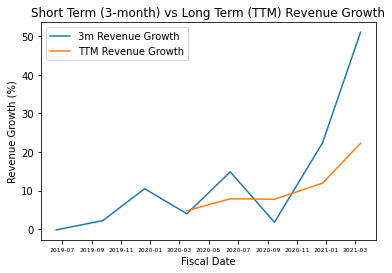

In [42]:
appl_rev_trend = revenue_history('AAPL', sandbox_params, 12)
print(appl_rev_trend)
plt.plot(appl_rev_trend['fiscalDate'], appl_rev_trend['Quarterly_Revenue_Growth'], label = "3m Revenue Growth")
plt.plot(appl_rev_trend['fiscalDate'], appl_rev_trend['TTM_Revenue_Growth'], label = "TTM Revenue Growth")
plt.xlabel('Fiscal Date')
plt.ylabel('Revenue Growth (%)')
plt.title('Short Term (3-month) vs Long Term (TTM) Revenue Growth')
plt.tick_params(axis='x', which='major', labelsize=6)
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [50]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3

In [51]:
#make sure MSNDATE is a datetime format
appl_2qrt_df['fiscalDate'] = pd.to_datetime(appl_2qrt_df['fiscalDate'], format='%Y/%m/%d')
p = figure(x_axis_type='datetime')

p.line(x='fiscalDate', y='Quarterly_Revenue_Growth', line_width=2, source=appl_2qrt_df, legend='Quarterly_Revenue_Growth')
p.line(x='fiscalDate', y='TTM_Revenue_Growth', line_width=2, source=appl_2qrt_df, color=Spectral3[2], legend='TTM_Revenue_Growth')

p.yaxis.axis_label = '3-Month vs TTM Revenue'

show(p)

In [17]:
# def historical_data(_symbol, _range=None, _date=None):
#     endpoint = f'{base_url}/stock/{_symbol}/chart'
#     if _range:
#         endpoint += f'/{_range}'
#     elif _date:
#         endpoint += f'/date/{_date}'
    
#     resp = requests.get(endpoint, params=params)
#     resp.raise_for_status()
#     return pd.DataFrame(resp.json())

In [26]:
#appl_3m_df = historical_data('AAPL', _range='1m')